## La spiegazione di questo codice forse la metto forse no, sicuro fa riferimento a record_linkage

In [2]:
import recordlinkage
from recordlinkage import Compare
from recordlinkage.preprocessing import clean
import pandas as pd

companies_df = pd.read_csv('../aziende_normalizzate.csv')

### Stai attento peró che con l'approccio sotto riportato 2 righe matchano solo se entrambi i valori fanno match
### **Miglioramento del Blocking con la Città e il Paese**

# **Obiettivo**
Migliorare il processo di blocking per la deduplicazione dei dati aziendali, in modo da evitare che il numero totale di coppie candidate basato sulla città sia uguale a quello basato sul paese, e aggiungere coppie candidate solo quando necessario.


In [3]:
indexer = recordlinkage.Index()
indexer.block(left_on=['company_name', 'city'])  #proviamo solo su normalizzazione

candidate_pairs = indexer.index(companies_df)

print(f'Numero di coppie candidate: {len(candidate_pairs)}')



Numero di coppie candidate: 2161


In [5]:
candidate_pairs_index = pd.MultiIndex.from_tuples(candidate_pairs, names=['left', 'right'])

companies_df = companies_df.reset_index(drop=True)

companies_df = companies_df.fillna("")

if companies_df['foundation_year'].dtype != 'int64':
    companies_df['foundation_year'] = pd.to_numeric(companies_df['foundation_year'], errors='coerce').fillna(0).astype(int)

if companies_df['number_of_employees'].dtype != 'int64':
    companies_df['number_of_employees'] = pd.to_numeric(companies_df['number_of_employees'], errors='coerce').fillna(0).astype(int)

compare = Compare()
compare.numeric('foundation_year', 'foundation_year', label='foundation_year')
compare.string('categories', 'categories', method='jarowinkler', threshold=0.85, label='categories')
compare.string('company_status', 'company_status', method='jarowinkler', threshold=0.85, label='company_status')
compare.string('website', 'website', method='jarowinkler', threshold=0.85, label='website')
compare.string('sector', 'sector', method='jarowinkler', threshold=0.85, label='sector')
compare.string('company_type', 'company_type', method='jarowinkler', threshold=0.85, label='company_type')
compare.string('rank', 'rank', method='jarowinkler', threshold=0.85, label='rank')
compare.numeric('number_of_employees', 'number_of_employees', label='number_of_employees')

try:
    features = compare.compute(candidate_pairs_index, companies_df)
    display(features.head(10))
except Exception as e:
    print("Errore durante il calcolo delle feature sull'intero dataset:", e)

,,foundation_year,categories,company_status,website,sector,company_type,rank,number_of_employees
left,right,,,,,,,,
13,12,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33,32,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
59,58,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
132,128,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
139,138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
143,142,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
182,181,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
209,208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
270,269,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
matches = features[features.sum(axis=1) > 2]

print(f'Numero di corrispondenze trovate: {len(matches)}')

matches.head()

Numero di corrispondenze trovate: 1628


,,foundation_year,categories,company_status,website,sector,company_type,rank,number_of_employees
left,right,,,,,,,,
13,12,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33,32,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
59,58,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
139,138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
143,142,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [11]:
grouped_matches = matches.loc[matches.sum(axis=1).groupby(level=0).idxmax()]

grouped_matches.head(100)

,,foundation_year,categories,company_status,website,sector,company_type,rank,number_of_employees
left,right,,,,,,,,
13,12,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33,32,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
59,58,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
139,138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
143,142,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
3864,3863,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3871,3870,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3874,3873,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
import networkx as nx

def merge_values(series):
    unique_values = set(series.dropna()) 
    return ' | '.join(map(str, unique_values)) if len(unique_values) > 0 else ''  
G = nx.Graph()
G.add_edges_from(grouped_matches.index.tolist())

connected_components = list(nx.connected_components(G))

duplicate_groups = {node: i for i, component in enumerate(connected_components) for node in component}

companies_df['group_id'] = companies_df.index.map(duplicate_groups)

def print_aggregated_rows(group_id, group_data):
    if len(group_data) >= 3:  
        print(f"\nAggregazione del gruppo {group_id} (con {len(group_data)} elementi):")
        group_data = group_data.reset_index()  
        print(group_data[['company_name', 'city', 'country', 'address']])  

final_df = companies_df.groupby('group_id').agg(merge_values).reset_index()

final_df = final_df.drop(columns=['group_id'])

for group_id, group_data in companies_df.groupby('group_id'):
    print_aggregated_rows(group_id, group_data)

final_df.to_csv("deduplicated_companies2.csv", index=False)

display(final_df.head())

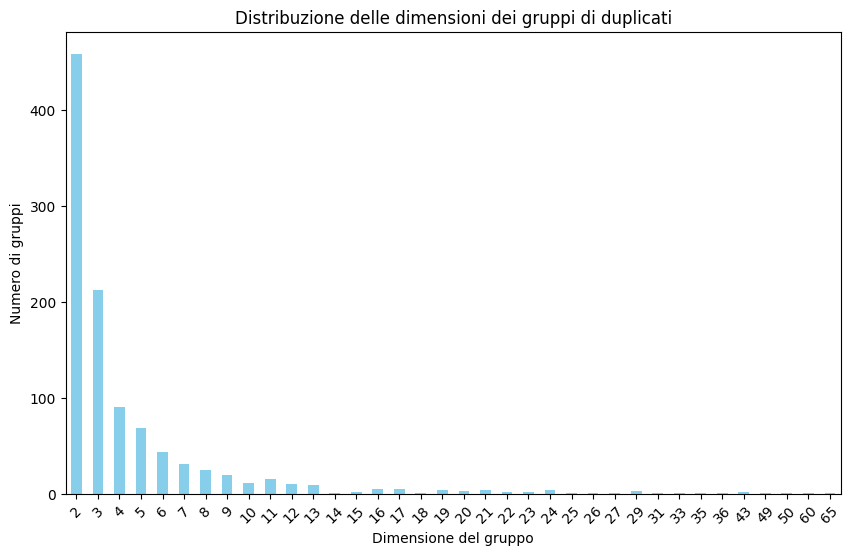

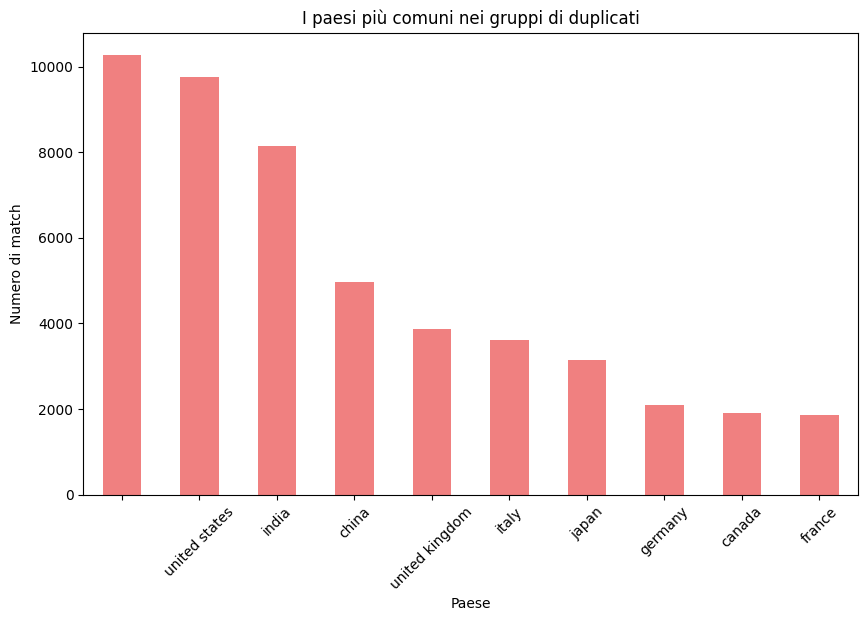

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


group_sizes = companies_df.groupby('group_id').size()

group_sizes_filtered = group_sizes[group_sizes > 1]

plt.figure(figsize=(10, 6))
group_sizes_filtered.value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.title('Distribuzione delle dimensioni dei gruppi di duplicati')
plt.xlabel('Dimensione del gruppo')
plt.ylabel('Numero di gruppi')
plt.xticks(rotation=45)
plt.show()


country_counts = companies_df['country'].value_counts()
plt.figure(figsize=(10, 6))
country_counts.head(10).plot(kind='bar', color='lightcoral')
plt.title('I paesi più comuni nei gruppi di duplicati')
plt.xlabel('Paese')
plt.ylabel('Numero di match')
plt.xticks(rotation=45)
plt.show()